In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
# data_generator.plot()

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0,1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
# data_generator_P.plot()

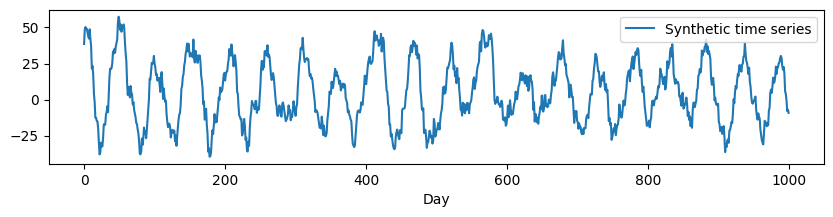

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

data_generator.plot()

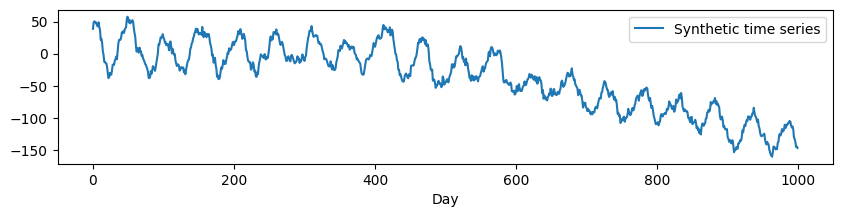

In [5]:
# Add anomaly
anm_pos = 400
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
LL_anm_mag = -20
for i in range(num_steps):
    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
    # if i >= anm_pos:
    #     data_generator.time_series['y'][i] += LL_anm_mag
data_generator.plot()

In [6]:
# # Save data_generator.time_series['y'] to .csv
# observation_file_paths = ['data/observation.csv', 'data/dummy.csv', 'data/dummy2.csv']
# datetime_file_paths = ['data/datetime.csv', 'data/dummy_datetime.csv', 'data/dummy_datetime2.csv']
# start_date = datetime(2000, 1, 1)
# indices_train_val_test = [1000, -1, -1]
# data_generator.time_step_interval = 7
# data_generator.export_to_csv(indices_train_val_test, observation_file_paths, datetime_file_paths, start_date)

In [7]:
from src.RL_functions.base_drift_candidate_models_all import *
prior_a = [0.998, 0.002]
trigger_pos = []

baseline_process_error_var_all = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# baseline_process_error_var_all = [1e-2]
x_likelihood_na_all = []
x_likelihood_a_all = []
y_likelihood_na_all = []
y_likelihood_a_all = []
LTd_na_all_models = []
LTd_a_all_models = []

######## Define the multivariate normal distribution ########
x_mulnorm_dist = estimate_hs_distribution_all_models(baseline_process_error_var_all, num_steps, AR_param_phi, AR_param_var, time_step_interval)

for baseline_process_error_var in baseline_process_error_var_all:
    x_likelihood_na, x_likelihood_a, y_likelihood_na, y_likelihood_a, LTd_na_one_model, LTd_a_one_model = base_drift_candidate_model(baseline_process_error_var, trigger_pos, data_generator, num_steps, AR_param_phi, AR_param_var, time_step_interval)
    # x_likelihood_na_all.append(x_likelihood_na)
    # x_likelihood_a_all.append(x_likelihood_a)
    y_likelihood_na_all.append(y_likelihood_na)
    y_likelihood_a_all.append(y_likelihood_a)
    LTd_na_all_models.append(LTd_na_one_model)
    LTd_a_all_models.append(LTd_a_one_model)

# Reshape
# x_likelihood_na_all = np.array(x_likelihood_na_all).reshape(len(baseline_process_error_var_all), num_steps)
# x_likelihood_a_all = np.array(x_likelihood_a_all).reshape(len(baseline_process_error_var_all), num_steps)
y_likelihood_na_all = np.array(y_likelihood_na_all).reshape(len(baseline_process_error_var_all), num_steps)
y_likelihood_a_all = np.array(y_likelihood_a_all).reshape(len(baseline_process_error_var_all), num_steps)
LTd_na_all_models = np.array(LTd_na_all_models).reshape(len(baseline_process_error_var_all), num_steps).transpose(1, 0)
LTd_a_all_models = np.array(LTd_a_all_models).reshape(len(baseline_process_error_var_all), num_steps).transpose(1, 0)

# Use new x_likelihood_na_all
x_likelihood_na_all = x_mulnorm_dist.pdf(LTd_na_all_models)
x_likelihood_a_all = x_mulnorm_dist.pdf(LTd_a_all_models)
print('The new x_likelihood_na_all is: ')
print(x_likelihood_na_all)
print('The new x_likelihood_a_all is: ')
print(x_likelihood_a_all)

# p_a0 = y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] / \
#             (y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] + \
#              np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
# p_a0 = y_likelihood_na_all[0] * x_likelihood_na_all * prior_a[0] / \
#             (y_likelihood_na_all[0] * x_likelihood_na_all * prior_a[0] + \
#              np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
p_a0 = y_likelihood_na_all[0] * x_likelihood_na_all * prior_a[0] / \
            (y_likelihood_na_all[0] * x_likelihood_na_all * prior_a[0] + \
             np.sum(y_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0) * x_likelihood_a_all)

p_na0 = []
for j in range(len(baseline_process_error_var_all)):
    # p_aj = y_likelihood_a_all[j] * x_likelihood_a_all[j] * prior_a[1]/len(baseline_process_error_var_all) / \
    #         (y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] + \
    #          np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
    p_aj = y_likelihood_a_all[j] * prior_a[1]/len(baseline_process_error_var_all) * x_likelihood_a_all / \
            (y_likelihood_na_all[0] * x_likelihood_na_all * prior_a[0] + \
             np.sum(y_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0) * x_likelihood_a_all)
    p_na0.append(p_aj)
    
p_na0 = np.array(p_na0).reshape(len(baseline_process_error_var_all), num_steps)

Estimating the multivariate normal distribution...
Correlation matrix of x_samples:
[[1.         0.85866165 0.57339747 0.32474583 0.16710586 0.08117276
  0.0444724  0.03477475]
 [0.85866165 1.         0.85437396 0.55266195 0.295715   0.13774209
  0.06156056 0.03862609]
 [0.57339747 0.85437396 1.         0.83970365 0.51927906 0.24824697
  0.08745986 0.0382369 ]
 [0.32474583 0.55266195 0.83970365 1.         0.82902704 0.47133981
  0.16774647 0.06443376]
 [0.16710586 0.295715   0.51927906 0.82902704 1.         0.78655413
  0.35308314 0.165426  ]
 [0.08117276 0.13774209 0.24824697 0.47133981 0.78655413 1.
  0.760078   0.52910685]
 [0.0444724  0.06156056 0.08745986 0.16774647 0.35308314 0.760078
  1.         0.9339869 ]
 [0.03477475 0.03862609 0.0382369  0.06443376 0.165426   0.52910685
  0.9339869  1.        ]]
The new x_likelihood_na_all is: 
[6.00720799e+012 6.00720799e+012 5.94881749e+012 5.49095679e+012
 5.01291571e+012 4.72023648e+012 3.90594889e+012 3.58137278e+012
 3.28223511e+012 2

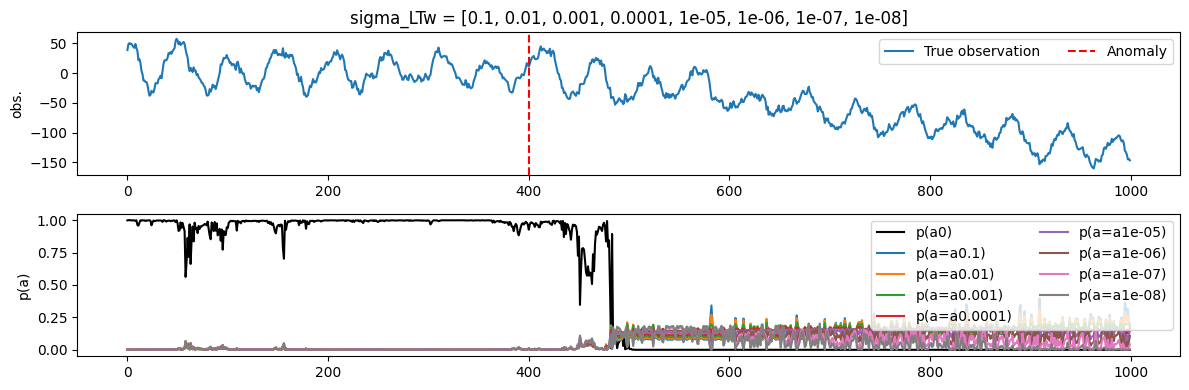

In [8]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[2])
# ax2 = plt.subplot(gs[3])
# ax3 = plt.subplot(gs[4])
# ax4 = plt.subplot(gs[5])
# ax5 = plt.subplot(gs[6])
# ax6 = plt.subplot(gs[7])
ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
ax0.legend(loc='upper right', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all))

ax1.plot(data_generator.time_series['timesteps'], p_a0, 'k', label='p(a0)')
# ax1.plot(data_generator.time_series['timesteps'], 1-p_a0, label='p(a=aj)')
for j in range(len(baseline_process_error_var_all)):
    ax1.plot(data_generator.time_series['timesteps'], p_na0[j], label='p(a=a' + str(baseline_process_error_var_all[j]) + ')')
ax1.set_ylabel('p(a)')
# ax1.set_ylim([0, 0.2])
ax1.legend(loc='upper right', ncol = 2)

# for j in range(len(baseline_process_error_var_all)):
#     ax2.plot(data_generator.time_series['timesteps'], p_na0[j], label='p(a=a' + str(baseline_process_error_var_all[j]) + ')')
# ax2.set_ylabel('p(a=aj)')
# ax2.legend(loc='upper left', ncol = 2)

# ax2.plot(data_generator.time_series['timesteps'], y_likelihood_a_all[0], label='action')
# ax2.plot(data_generator.time_series['timesteps'], y_likelihood_na_all[0], label='no action')
# ax2.set_ylabel('L_y')
# ax2.set_title('sigma_LTw = ' + str(baseline_process_error_var_all[0]))
# ax2.legend(loc='upper left', ncol = 2)

# ax3.plot(data_generator.time_series['timesteps'], x_likelihood_a_all[0], label='action')
# ax3.plot(data_generator.time_series['timesteps'], x_likelihood_na_all[0], label='no action')
# ax3.set_ylabel('L_x')
# ax3.legend(loc='upper left', ncol = 2)

In [9]:
print('probabilities of 8 models (aj):')
print(p_na0[:,90])
print('probabilities of a0:')
print(p_a0[90])

print(np.sum(p_na0[:,90])+p_a0[90])


probabilities of 8 models (aj):
[0.00802793 0.00907193 0.01073054 0.01487187 0.01819427 0.01880159
 0.01886753 0.01887418]
probabilities of a0:
0.8825601490182599
1.0
